In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import datetime as dt
%matplotlib inline

In [2]:
# FUNCTIONS YOU CAN USE:
#     analyses(filepath) spits out a nifty heatmap to let you check correlation between variables
#
#     regress(option, df) churns out a saucy graph of the linear regression for the variables you provided, where
#       option is 'snr_total' or 'tsnr', whichever you want to make the dependent variable of your model
#       df is the pandas DataFrame containing your data. To modify which variables you want in your model, you'll
#             have to directly modify the regress function

In [3]:
# NOTABLE FILENAMES
# ../data/extractions/p2_BOLD.csv                  - all dates for p2_BOLD
# ../data/extractions/p2Xs4X35mm_BOLD.csv          - all dates for p2Xs4X35mm_BOLD
# ../data/extractions/anat.csv                     - all possible dates for anatomical data

In [4]:
def filter(option, df):
    is_p2 = df['Filetype'] == "task-rest_acq-p2_bold.json"
    is_x = df['Filetype'] == "task-rest_acq-p2Xs4X35mm_bold.json"
    
    if option == 'x':
        return df[is_x]
    elif option == 'p2':
        return df[is_p2]

In [5]:
def analyses(filepath):
    files = pd.read_csv(filepath)
    
    # FIRST CHECK: CONVERSION SOFTWARE VERSIONS
    check = files.iloc[0, 7]
    valid = True
    
    for i in files.index:
        if check != files.iloc[i, 7]:
            valid = False
            
    print("All Conversion Softwares are the same: " + str(valid))
    
    # SECOND CHECK: HEATMAP
    sns.heatmap(files.corr(), cmap=sns.diverging_palette(h_neg=240, h_pos=10, n=9, sep=1, center="dark"), center=0)

In [42]:
def regress(option, df):
    # creates a regression graph plotted against actual data from certain QA metrics
    # option: takes str value of either snr_total or tsnr to model against
    # df    : takes pandas DataFrame with data
    
    # checks parameters passed in
    if option != 'snr_total' and option != 'tsnr':
        return "Option must be snr_total or tsnr"
    
    elif type(df) is not pd.core.frame.DataFrame:
        return "DataFrame must be of type pandas.core.frame.DataFrame"
    
    # preparing sin and cos curves to add to the model
    n = len(df)
    date = str(df.iat[0,0])
    values = [np.sin(np.pi*i/(26)) for i in range(n)]
    values2 = [np.cos(np.pi*i/(26)) for i in range(n)]
    dates = [dt.datetime(int(date[:4]), int(date[4:6]), int(date[6:])) + dt.timedelta(days = i*7) for i in range(n)]

    sin = pd.DataFrame(values)
    sin.columns = ['seasonal (sin)']
    
    cos = pd.DataFrame(values2)
    cos.columns = ['seasonal (cos)']
    
    df = df.join(sin)
    df = df.join(cos)
    
    # Converting date to a format that can be parsed by statsmodels API
    df['Date'] = pd.to_datetime(df['Date'], format="%Y%m%d")
    df['Date2'] = df['Date'].map(pd.datetime.toordinal)
    
    # Assigning independent and dependent variables
    list = []
    
    for item in df.std().iteritems():
        if item[0] != 'Date' and item[0] != option and item[1] != 0:
            list.append(item[0])
    
    X = df[list]
    X = sm.add_constant(X)
    y = df[option]
    
    # modeling predictions
    model = sm.OLS(y, X).fit()
    predictions = model.predict(X)
    
    # converting the above predictions to a format that can be plotted
    prediction = predictions.to_frame()
    prediction.columns = ['model']
    df2 = df.join(prediction)
    
    # plotting the graph
    plt.figure(figsize=(15, 6))

    ax = sns.lineplot(x="Date", y=option, data=df2, color="#ff9933")
    ax_txrefamp = plt.twinx()
    sns.lineplot(x="Date", y="model", data=df2, color="r", ax=ax)
    ax.legend([option, 'predicted value'])

    plt.plot(dates,values, color='#A9A9A9', label="seasonal (sin)")
    plt.plot(dates,values2, color='#A9A9A9', label="seasonal (cos)")
    plt.legend(['seasonal (sin)', 'seasonal (cos)'], loc='upper left')
    
    # giving additional data
    print(model.summary())
    
    if 'Shim1' and 'Shim2' and 'Shim3' and 'Shim4' and 'Shim5' and 'Shim6' and 'Shim7' and 'Shim8' in list:
        print("Shim F-test: ")
        print(model.f_test("Shim1 = Shim2 = Shim3 = Shim4 = Shim5 = Shim6 = Shim7 = Shim8 = 0"))
    
    if 'IOPD1' and 'IOPD2' and 'IOPD3' and 'IOPD4' and 'IOPD5' and 'IOPD6' in list:
        print("IOPD F-test: ")
        print(model.f_test("IOPD1 = IOPD2 = IOPD3 = IOPD4 = IOPD5 = IOPD6 = 0"))
    
    print("Seasonal F-test:")
    print(model.f_test("seasonal (sin) = seasonal (cos) = 0"))

All Conversion Softwares are the same: True


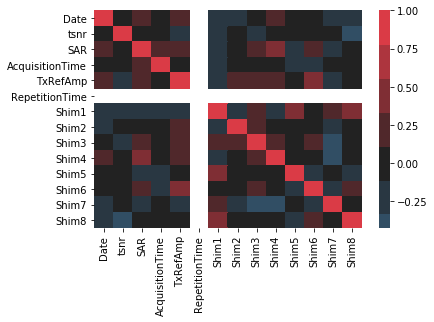

In [6]:
analyses('../data/extractions/p2_BOLD.csv')

All Conversion Softwares are the same: True


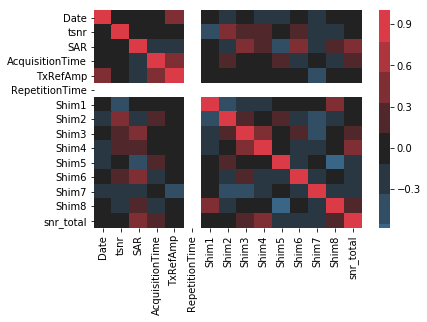

In [7]:
analyses('../data/extractions/p2_BOLD_snr.csv')

In [6]:
files = pd.read_csv('../data/extractions/p2_BOLD.csv')
df = pd.DataFrame(files,columns=['Date', 'tsnr', 'TxRefAmp', 'AcquisitionTime', 'SAR',
                                'RepetitionTime', 'Shim1', 'Shim2', 'Shim3', 'Shim4',
                                'Shim5', 'Shim6', 'Shim7', 'Shim8'])

In [7]:
# p2Xs4X35mm_BOLD.csv
files2 = pd.read_csv('../data/extractions/p2Xs4X35mm_BOLD.csv')
df2 = pd.DataFrame(files2,columns=['Date', 'tsnr', 'TxRefAmp', 'AcquisitionTime', 'SAR',
                                'RepetitionTime', 'Shim1', 'Shim2', 'Shim3', 'Shim4',
                                'Shim5', 'Shim6', 'Shim7', 'Shim8'])

In [44]:
files3 = pd.read_csv('../data/extractions/anat.csv')
df3 = pd.DataFrame(files3,columns=['Date', 'snr_total', 'TxRefAmp', 'AcquisitionTime', 'SAR',
                                'RepetitionTime', 'Shim1', 'Shim2', 'Shim3', 'Shim4',
                                'Shim5', 'Shim6', 'Shim7', 'Shim8', 'IOPD1', 'IOPD2', 'IOPD3', 'IOPD4',
                                'IOPD5', 'IOPD6'])